In [1]:
import os
import numpy as np
import skimage
from skimage import io
from skimage import color
from skimage import transform
import cv2

from random import shuffle

import matplotlib.pyplot as plt 
import io
import pickle
import threading
%matplotlib inline

Цель данной работы - получить базовые навыки обработки изображений и видео.

Для этой работы нам понядобятся данные из директории data/0\_raw\_video. Входные данные представляют собой набор видео. Каждое видео представлено в виде отдельной директории, хранящей последовательность кадров видео в формате JPEG [NNNN].[jpg,jpeg] + файл timestamp.txt, хранящий информацию о временных метках (в мс) каждого кадра. Директория видео имеет следующий формат: [person ID]\_[session ID]\_[phrase ID]\_\*, где [phrase ID] состоит из цифр, произнесенных пользователем.

Для каждого кадра имеется файл [].landmarks, хранящий координаты характеристических точек в соотстветвии с рисунком:
![title](img/figure_68_markup.jpg)


In [7]:
# Функция загрузки временных меток видео
def read_timestamps(timestamps_filename):
    timestamps = []
    if not os.path.isfile(timestamps_filename):
        print("WARNING! can't open timestamps file: " + timestamps_filename)
        return []
    timestamps_lines = [l.strip() for l in open(timestamps_filename).readlines()]
    timestamps_raw = []
    for l in timestamps_lines:
        timestamps_raw = timestamps_raw + l.split(' ')
    if len(timestamps_raw) % 2 != 0:
        print("WARNING! can't parse timestamps file: " + timestamps_filename)
        return []
    for i in range(0, int(len(timestamps_raw)/2)):
        if ':' not in timestamps_raw[i*2]:
            print("WARNING! can't parse timestamps file: " + timestamps_filename + ", ts: " + timestamps_raw[i*2])
            return []
        timestamps.append([timestamps_raw[i*2].split(':')[0], float(timestamps_raw[i*2 + 1])])
    return timestamps

In [8]:
# Функция загрузки разметки характеристических точек лица
def read_landmarks(landmarks_filename):
    if not os.path.isfile(landmarks_filename):
        print("WARNING! can't open timestamps file: " + landmarks_filename)
        return np.array([])
    landmarks = [[float(l.split('\t')[0]), float(l.split('\t')[1])] for l in open(landmarks_filename).readlines()]
    return np.array(landmarks)

<b>Задание 1.</b> Прочитать любую картинку + landmarks из любого видео и отрисовать при помощи matplotlib

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

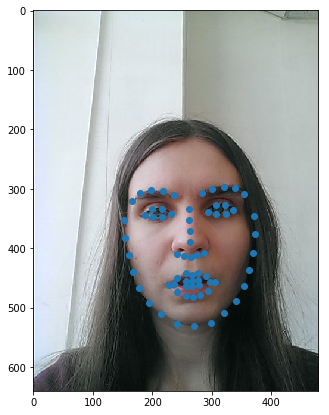

In [10]:
work_dir = "/Users/artbataev/Programming/machine_learning/sr_ifmo/data/lip_reading/"
video_dir =  work_dir + "0_raw_video/"

#------ TODO ---------------
img_file = os.path.join(video_dir, "F0014_02_17538_Android_htc", "0000.jpg")
landmarks_file = img_file + ".landmarks"

img = skimage.io.imread(img_file)
landmards = read_landmarks(landmarks_file)
plt.imshow(img)
plt.scatter(landmards[:, 0], landmards[:, 1])
plt.show()

#---------------------------

<b>Задание 2.</b> Провести следующую цепочку преобразований для видео:

- Прочитать изображения в черно-белом формате
- Повернуть изображение так, чтобы глаза находились строго горизонтально
- Вырезать область губ с разрешением 100x60
- Оставить только landmarks с координатами губ и привести их в соответствие с вырезанным изображением


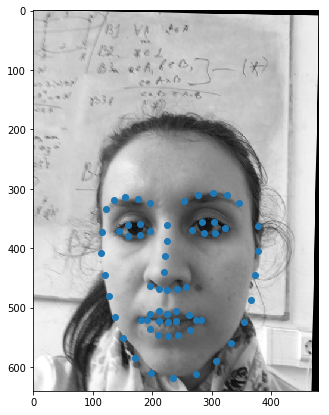

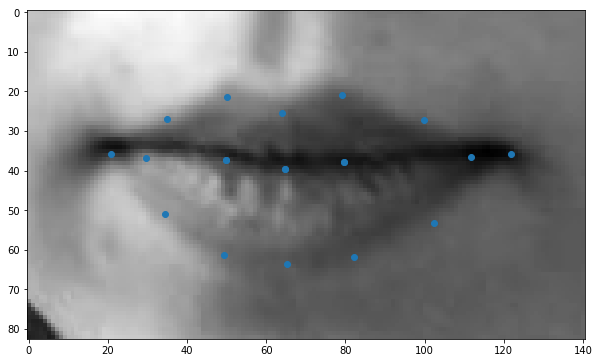

/Users/artbataev/.virtualenvs/ml3gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


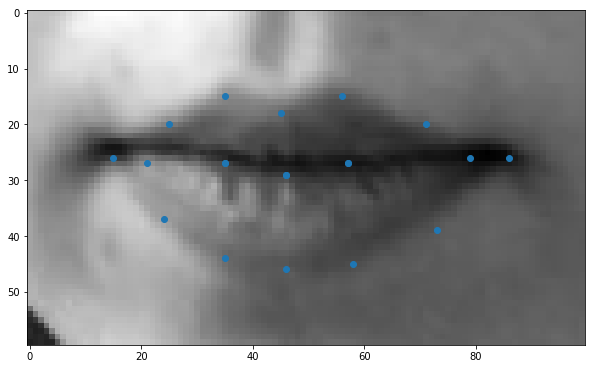

(60, 100)


In [11]:
img_file = os.path.join(video_dir, "F0248_01_08493_iPhone_6S", "0000.jpeg")

landmarks_file = img_file + ".landmarks"
img_gray = skimage.io.imread(img_file, as_grey=True)
lm = read_landmarks(landmarks_file)
# 2. rotate image, coords
x1, y1, x2, y2 = lm[48, 0], lm[48, 1], lm[54, 0], lm[54, 1] 
angle = np.arctan2(y2-y1, x2-x1)
tform = transform.AffineTransform(rotation=-angle)
rotated_img = transform.warp(img_gray, tform.inverse)
transformed_lm = transform.matrix_transform(lm, tform.params)

plt.imshow(rotated_img, cmap="gray")
plt.scatter(transformed_lm[:, 0], transformed_lm[:, 1])
plt.show()
# 3. crop mouth
x_min = int(max(np.min(transformed_lm[48:68, 0]) - 20, 0))
x_max = int(np.max(transformed_lm[48:68, 0]) + 20)
y_min = int(max(np.min(transformed_lm[48:68, 1]) - 20, 0))
y_max = int(np.max(transformed_lm[48:68, 1]) + 20)
cropped_img = rotated_img[y_min:y_max, x_min:x_max]
cropped_lm = transformed_lm[48:68, :] - np.array([x_min, y_min], dtype=np.float)

plt.imshow(cropped_img, cmap="gray")
plt.scatter(cropped_lm[:, 0], cropped_lm[:, 1])
plt.show()

final_img = transform.resize(cropped_img, output_shape=[60, 100])
final_lm = np.round(cropped_lm * np.array([100 / cropped_img.shape[1], 60 / cropped_img.shape[0]]))
plt.imshow(final_img, cmap="gray")
plt.scatter(final_lm[:, 0], final_lm[:, 1])

plt.show()
print(final_img.shape)

In [214]:
def process_sessions(sessions, results_data_path, verbose=False):
    try:
        for session in sessions:
            timestamps = read_timestamps(session + "/timestamp.txt")

            image_shape = np.array([100, 60])
            landmarks_num = 68
            landmarks_mouth_num = 20

            data_img = np.zeros([len(timestamps), image_shape[0], image_shape[1]], dtype=np.float32)
            data_lm =  np.zeros([len(timestamps), landmarks_mouth_num, 2], dtype=np.float32)
            data_ts =  np.zeros([len(timestamps)], dtype=np.float32)
            frames = []



            session_name = session[session.rfind('/')+1:]
            print ("PROCESS: " + session_name)



            max_time = 0
            counter = 0
        
        
            for frame, time in timestamps:
                if time <= max_time: # bug fix
                    continue
                max_time = time
                image_filename = session + "/" + frame + ".jpg"
                if not os.path.isfile(image_filename):
                    image_filename = session + "/" + frame + ".jpeg"
                if not os.path.isfile(image_filename):
                    continue

                lm = read_landmarks(image_filename + ".landmarks")
                if (lm.shape[0] != landmarks_num):
                    continue
                
                # ------ TODO ---------------------------
                # 1. Прочитать изображение
                # 2. Повернуть
                # 3. Вырезать изображение рта         
                # 4. Оставить 20 landmarks изображения рта
                # 5. Сохранить в соответствующие массивы:
                #    data_img[counter,:,:] = 
                #    data_lm[counter,:,:] = (lm[48:68,:] - crop_bound[0]) * scale_factor
                #    data_ts[counter] = time
                # ---------------------------------------
                # 1. read
                img_gray = skimage.io.imread(image_filename, as_grey=True)
                
                # 2. rotate image, coords
                x1, y1, x2, y2 = lm[48, 0], lm[48, 1], lm[54, 0], lm[54, 1] 
                angle = np.arctan2(y2-y1, x2-x1)
                tform = transform.AffineTransform(rotation=-angle)
                rotated_img = transform.warp(img_gray, tform.inverse)
                transformed_lm = transform.matrix_transform(lm, tform.params)

                # 3=4. crop mouth, 20 landmarks
                x_min = int(max(np.min(transformed_lm[48:68, 0]) - 20, 0))
                x_max = int(np.max(transformed_lm[48:68, 0]) + 20)
                y_min = int(max(np.min(transformed_lm[48:68, 1]) - 20, 0))
                y_max = int(np.max(transformed_lm[48:68, 1]) + 20)
                cropped_img = rotated_img[y_min:y_max, x_min:x_max]
                cropped_lm = transformed_lm[48:68, :] - np.array([x_min, y_min], dtype=np.float)
                final_img = transform.resize(cropped_img, output_shape=[60, 100])
                final_lm = np.round(cropped_lm * np.array([100 / cropped_img.shape[1], 60 / cropped_img.shape[0]]))
                
                # 5 save
                data_img[counter,:,:] = final_img.T
                data_lm[counter,:,:] = final_lm
                data_ts[counter] = time
                # end my code
                if verbose:
                    print(image_filename)
                    plt.imshow(final_img, cmap="gray")
                    plt.show()
                
                frames.append(frame)
                counter = counter + 1
               
            data_img = np.resize(data_img, [counter, image_shape[0], image_shape[1]])
            data_lm =  np.resize(data_lm,  [counter, landmarks_mouth_num, 2])
            data_ts =  np.resize(data_ts,  [counter, 1])
            
            # сохраняем данные в бинарный файл при помощи библиотеки pickle
            with open(results_data_path + session_name + ".pickle", "wb") as f:
                pickle.dump(data_img, f)
                pickle.dump(data_lm, f)
                pickle.dump(data_ts, f)
                pickle.dump(frames, f)
    except:
        print ("ERROR! can't process session: " + session_name)

Обработаем все видео

In [215]:
# process_sessions([os.path.join(video_dir, "F0248_01_08493_iPhone_6S")], results_data_path, verbose=True)

In [216]:
results_data_path = work_dir + "1_video_lips/"
#os.system("mkdir " + results_data_path)
sessions = [(video_dir + d) for d in os.listdir(video_dir) if not ".ds_store" in d.lower()]

process_sessions(sessions, results_data_path)


PROCESS: F0014_02_17538_Android_htc
PROCESS: F0224_02_73981_Android_SM
PROCESS: F0248_01_08493_iPhone_6S
PROCESS: F0308_02_5329084671_Android_SM
PROCESS: F037_02_42365_iPhone_iphone6
PROCESS: M0284_01_17263_Android_SM
PROCESS: M0562_01_1209674835_iPhone_6S
PROCESS: M0567_01_2793086514_Android_SM
PROCESS: M0602_01_40792_iPhone_6S


Проветим корректность полученных данных

float32
(124, 1)
[ 1840.]
0055


/Users/artbataev/.virtualenvs/ml3/lib/python3.4/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


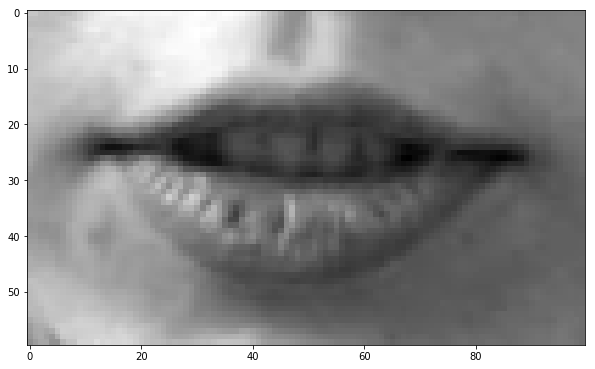

In [217]:
with open(results_data_path + "F0248_01_08493_iPhone_6S.pickle", "rb") as f:
# with open(results_data_path + "F0014_02_17538_Android_htc.pickle", "rb") as f:
    data_img_test = pickle.load(f)
    data_lm_test = pickle.load(f)
    data_ts_test = pickle.load(f)
    frames_test = pickle.load(f)

index = 55
plt.imshow(data_img_test[index,:,:].transpose(), cmap='gray')
print(data_img_test.dtype)
print(data_ts_test.shape)
print(data_ts_test[index])
print(frames_test[index])
debug_path = work_dir + "debug/"

lm_indices = data_lm_test.astype(dtype=np.int32)
for i in range(0, len(frames_test)):
    for indx in lm_indices[i,:,:]:
        data_img_test[i, indx[0]-2:indx[0]+2, indx[1]-2:indx[1]+1] = 0
    skimage.io.imsave(debug_path + frames_test[i] + ".png", data_img_test[i,:,:].transpose())

<b> Задание 3*</b>. Попробуйте обучить детектор рта. Данные для обучения и тестирования лежат в папке landmarks_dataset

bimodal_ld_kor_ready.zip, bimodal_ld_por_ready.zip, bimodal_ld_rus_ready.zip - данные обучения
bimodal_ld_wf_kovpak_ready.zip - данные для тестирования


\* для тех, кто всё сделал и осталось много времени